- Try a simple stock market RL algo. 
- Construct a stock market env, keep original Actor-critic PG.


For a simple time series stock, we define:
- A, [Buy = 1, Hold = 0, Sell = -1]
- State Market, [O, H, L, C, V, P(portifolioProce)]
- Reawrd is calculated as holding return each trading day

In [1]:
import tushare as ts

In [2]:
df = ts.get_k_data(code='000001', start='2000-01-01', index=True)

[Errno 54] Connection reset by peer
[Errno 54] Connection reset by peer


In [3]:
df = df.ix[:, 1:-1]*0.01
df.head()

,open,close,high,low,volume
0,13.6869,14.0637,14.0752,13.6121,90340.2
1,14.0783,14.0968,14.3378,13.9832,105800.0
2,14.0604,14.6394,14.6395,14.0025,134805.0
3,14.7715,15.1660,15.2282,14.7715,345157.0
4,15.3171,15.4511,15.4672,15.0640,312535.0


In [59]:
class portfilio:
    def __init__(self, initail=1000, trans=0.0005):
        self.balence = initail
        self.trans = trans
        self.record = [initail]
        
        self.hold = 0
        self.done = False
        self.total = initail
        self.reward = 0
    def order(self, o_type, close, amount=10):
        if o_type == 1: # sell
            if self.hold >= amount:
                self.balence += (1-self.trans)*(close*amount)
                self.hold -= amount
        elif o_type == 2: # buy
            
            self.balence -= (1+self.trans)*(close*amount)
            if self.balence <= 0 :
                self.done = True
            else:
                self.hold += amount
        self.total = self.balence + self.hold*close
        self.record += [self.total]
        #print('Balence: {0}, Holds: {1}, Total: {2}, Earn {3}'.format(self.balence,self.hold,self.total,-self.record[0]+self.total))
            

In [5]:
class Market:
    def __init__(self, df):
        self.market = df.values
        self.market_g = self._market_g()
        self.port = portfilio()
        
        self.num_state = 6
        self.num_action = 3
    
    
    def reset(self):
        self.market_g = self._market_g()
        self.port = portfilio()
        
        state = []
        for _ in range(5):
            o,h,l,c,v = next(self.market_g)
            v /= 100000.
            self.c = c
            state += [[o,h,l,c,v, self.port.balence]]
        self.state = state
        return state
        
    def _market_g(self):
        for o,h,l,c,v in self.market:
            yield o,h,l,c,v
            
    def step(self, action):
        if not self.port.done:
            self.port.order(action, self.c)
            
            self.state.pop(0)
            
            o,h,l,c,v = next(self.market_g)
            self.state += [[o,h,l,c,v, self.port.balence]]
            
            reward = self.port.hold * c
            return self.state, reward, self.port.done
        else:
            print('bankrupt!')
        
        

In [6]:
from tensorflow.python.ops import rnn_cell
import tensorflow as tf

In [60]:
class PolicyEstimator:
    def __init__(self, learning_rate = 0.0001, scope='PolicyEstimator'):
        num_units = 100
        num_layers = 3
        num_actions = 3
        time_steps = 5
        num_features = 6
        
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [1, time_steps, num_features])
            self.action = tf.placeholder(tf.int32)
            self.target = tf.placeholder(tf.float32)

            cell_fn = rnn_cell.BasicLSTMCell(num_units=num_units, state_is_tuple=True)
            cell = rnn_cell.MultiRNNCell([cell_fn]*num_layers, state_is_tuple=True)


            state = tf.unpack(tf.transpose(self.state, perm=[1, 0, 2]))

            outputs, state_rnn = tf.nn.rnn(cell, state, dtype=tf.float32)

            weight = tf.Variable(tf.truncated_normal([num_units, num_actions], stddev=0.1))
            bias = tf.Variable(tf.constant(0.1, shape=[3]))

            self.prediction = tf.nn.softmax(tf.matmul(outputs[-1], weight) + bias)
            self.action_prob = tf.gather(tf.squeeze(self.prediction), self.action)

            self.loss = - tf.log(self.action_prob) * self.target


            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())

    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.prediction, { self.state: [state] })[0]

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: [state], self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [8]:
m = Market(df)
m.reset()
state, r, d = m.step(2)


Balence: 849.28468, Holds: 10, Total: 999.92468, Earn -0.07532000000003336


In [9]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)



NameError: name 'pe' is not defined

In [45]:
pe = PolicyEstimator(scope='V22222')

In [46]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    pro = pe.predict(np.array([state]), sess=sess)

In [48]:
pro[0]

array([ 0.30726889,  0.32688516,  0.36584598], dtype=float32)

In [44]:
pro

-0.014547385

In [16]:
np.array([state]).shape

(1, 5, 6)

In [37]:
pro

-0.014547385

In [15]:
state

[[14.078299999999999,
  14.096800000000002,
  14.3378,
  13.9832,
  1.0580000000000001,
  1000],
 [14.0604, 14.6394, 14.6395, 14.0025, 1.34805, 1000],
 [14.771500000000001,
  15.165999999999999,
  15.228199999999999,
  14.771500000000001,
  3.4515699999999998,
  1000],
 [15.3171,
  15.451099999999999,
  15.4672,
  15.064000000000002,
  3.1253500000000001,
  1000],
 [15.476800000000001,
  14.797800000000001,
  15.4771,
  14.6876,
  219246.0,
  849.28467999999998]]

In [61]:
class ValueEstimator:
    def __init__(self, learning_rate = 0.0001, scope='ValueEstimator'):
        num_units = 100
        num_layers = 3

        time_steps = 5
        num_features = 6
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [1, time_steps, num_features])
            self.target = tf.placeholder(tf.float32)

            cell_fn = rnn_cell.BasicLSTMCell(num_units=num_units, state_is_tuple=True)
            cell = rnn_cell.MultiRNNCell([cell_fn]*num_layers, state_is_tuple=True)


            state = tf.unpack(tf.transpose(self.state, perm=[1, 0, 2]))

            outputs, state_rnn = tf.nn.rnn(cell, state, dtype=tf.float32)

            weight = tf.Variable(tf.truncated_normal([num_units, 1], stddev=0.1))
            bias = tf.Variable(tf.constant(0.1, shape=[1]))


            self.value_estimate = tf.squeeze(tf.matmul(outputs[-1], weight) + bias)
            self.loss = tf.squared_difference(self.value_estimate, self.target)


            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())

    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: [state] })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: [state], self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [11]:
%matplotlib inline


import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting

matplotlib.style.use('ggplot')

In [40]:
env = Market(df)

In [62]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [65]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(scope='252941')
value_estimator = ValueEstimator(scope='2205553')

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~300 seemed to work well for me.
    stats = actor_critic(env, policy_estimator, value_estimator, 900)

Step 6 @ Episode 900/900 (3829.601000000001)

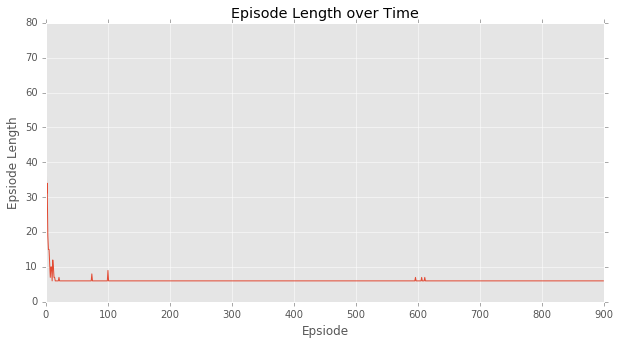

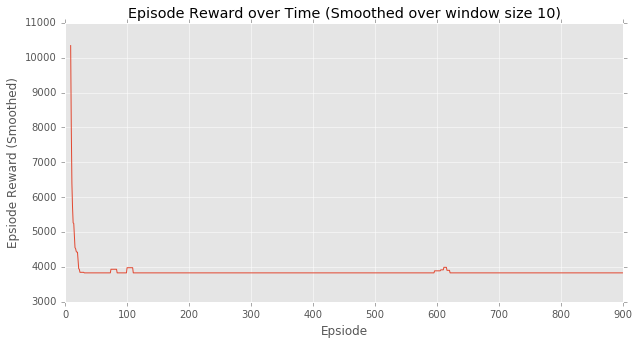

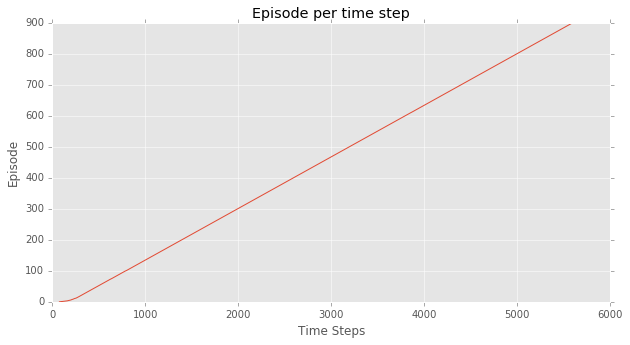

(<matplotlib.figure.Figure at 0x11ee83ac8>,
 <matplotlib.figure.Figure at 0x120576d68>)

In [66]:
plotting.plot_episode_stats(stats, smoothing_window=10)